# Custom model training for gesture recognition

Import the required libraries

In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2024-10-24 16:47:01.354243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 16:47:01.612983: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 16:47:01.613770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 16:47:02.723081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the list of gesture form the `gesture_list.csv` file

In [2]:
# Define which gestures should be detected by the model
gesture_list = np.loadtxt("gesture_list.csv", delimiter=',', dtype=str)
print(gesture_list)
num_gestures = len(gesture_list)

['none' 'open' 'fist' 'index' 'L']


Load the dataset from the file

In [3]:

dataset_filepath = "dataset.csv"
handedness = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.str_, usecols=(0))
y_data_labels = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.str_, usecols=(1))
x_data = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.float32, usecols=list(range(2, (21*3)+2)))

In [4]:
print(handedness[0])
print(y_data_labels[0])
print(x_data.shape)
print(x_data[0].shape)

Left
open
(1194, 63)
(63,)


In [5]:
unique, counts = np.unique(y_data_labels, return_counts=True)
label_count = dict(zip(unique, counts))
for elem in label_count:
    print(f"{elem}: {label_count[elem]}")

L: 300
fist: 394
index: 300
open: 200


Normalize data: convert to N x 21 x 3 -> normalization -> convert to N x 63

In [6]:
N = x_data.shape[0]
x_data_tensor = np.zeros((N,21,3))
for i in range(N):
    for j in range(21):
        for k in range(3):
            x_data_tensor[i,j,k] = x_data[i, 3*j+k]

assert x_data[200,15] == x_data_tensor[200, 5, 0]

from custom_model.landmark_normalizer import normalize_landmarks
    
x_data_normalized = np.zeros_like(x_data)
for i, gesture in enumerate(x_data_tensor):
    x_data_normalized[i] = normalize_landmarks(gesture, handedness[i]).reshape(-1)
    
assert x_data_normalized.shape == x_data.shape

x_data = x_data_normalized

Define the ID of each gesture. The ID coincides with the row number in the file

In [7]:
y_data = np.zeros((y_data_labels.shape[0]))
for i, label in enumerate(y_data_labels):
    for j, gesture in enumerate(gesture_list):
        if label == gesture and gesture in gesture_list:
            # "Substitute" the label with the gesture id
            y_data[i] = j

Split the dataset into training and validation sets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.75)
print(f"Y training set: {y_train}")

Y training set: [3. 2. 4. 3. 4. 1. 3. 3. 3. 2. 4. 3. 2. 2. 2. 3. 3. 4. 4. 3. 3. 2. 3. 3.
 2. 4. 3. 4. 2. 1. 3. 2. 2. 4. 2. 1. 4. 4. 1. 4. 4. 1. 1. 4. 4. 3. 3. 3.
 3. 3. 1. 4. 1. 4. 2. 4. 3. 3. 3. 2. 4. 1. 3. 1. 1. 4. 1. 2. 2. 2. 2. 1.
 4. 4. 2. 3. 3. 3. 4. 2. 2. 1. 2. 3. 2. 2. 1. 4. 1. 3. 4. 2. 3. 1. 1. 3.
 2. 1. 1. 3. 2. 4. 4. 2. 3. 2. 2. 3. 3. 2. 3. 2. 4. 3. 2. 2. 1. 1. 3. 2.
 1. 4. 4. 3. 4. 2. 4. 2. 2. 4. 2. 1. 1. 2. 2. 3. 4. 2. 1. 1. 4. 3. 2. 3.
 2. 1. 2. 2. 4. 4. 3. 3. 3. 1. 4. 2. 2. 2. 2. 3. 4. 3. 2. 2. 2. 2. 1. 2.
 4. 3. 3. 3. 2. 2. 2. 2. 1. 4. 2. 3. 3. 3. 2. 2. 3. 4. 3. 4. 1. 3. 2. 1.
 4. 1. 2. 4. 2. 2. 2. 1. 2. 4. 4. 2. 1. 4. 4. 3. 2. 2. 3. 3. 2. 2. 2. 3.
 2. 3. 1. 4. 4. 2. 3. 2. 2. 4. 2. 3. 4. 4. 4. 2. 1. 2. 3. 4. 1. 4. 4. 2.
 2. 2. 3. 1. 4. 4. 2. 3. 3. 3. 1. 4. 2. 2. 4. 2. 3. 3. 3. 4. 3. 2. 4. 3.
 1. 2. 4. 2. 3. 4. 2. 3. 4. 4. 2. 3. 2. 3. 3. 3. 3. 3. 1. 2. 3. 1. 3. 4.
 3. 1. 4. 3. 3. 3. 4. 3. 4. 4. 4. 4. 3. 4. 1. 3. 2. 4. 1. 4. 3. 1. 3. 1.
 3. 1. 3. 1. 4. 2. 1. 2. 1. 3. 2. 1

Define the model architechture

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(num_gestures, activation='softmax')
])
model.summary()

# Path where to save the model
model_save_path = "model/gesture_classifier.keras"
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 20)                1280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1545 (6.04 KB)
Trainable params: 1545 (6.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training step

In [11]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 [===>..........................] - ETA: 3s - loss: 2.0870 - accuracy: 0.2500
Epoch 1: saving model to model/gesture_classifier.keras
7/7 [==============================] - 1s 37ms/step - loss: 1.9191 - accuracy: 0.2179 - val_loss: 1.4781 - val_accuracy: 0.2241
Epoch 2/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.9263 - accuracy: 0.1875
Epoch 2: saving model to model/gesture_classifier.keras
7/7 [==============================] - 0s 8ms/step - loss: 1.7614 - accuracy: 0.2179 - val_loss: 1.3835 - val_accuracy: 0.3478
Epoch 3/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.7175 - accuracy: 0.2422
Epoch 3: saving model to model/gesture_classifier.keras
7/7 [==============================] - 0s 9ms/step - loss: 1.6206 - accuracy: 0.2525 - val_loss: 1.3425 - val_accuracy: 0.4247
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.6282 - accuracy: 0.2422
Epoch 4: saving model to model/gesture_classifier.keras
7/7 [=============

Validation step

In [12]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

3/3 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9799


Save the model with inference optimizations

In [13]:
model.save(model_save_path)

## Confusion matrix

10/10 [==============================] - 0s 823us/step


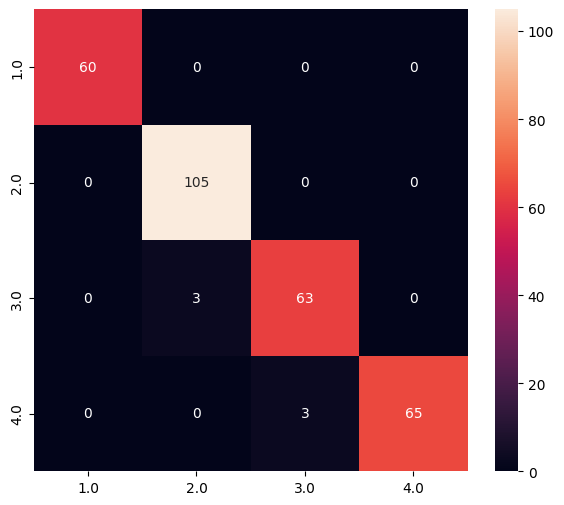

Classification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        60
         2.0       0.97      1.00      0.99       105
         3.0       0.95      0.95      0.95        66
         4.0       1.00      0.96      0.98        68

    accuracy                           0.98       299
   macro avg       0.98      0.98      0.98       299
weighted avg       0.98      0.98      0.98       299



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [15]:
i = 678
predict_result = model.predict(np.array([x_data[i]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(y_data[i])

1/1 [==============================] - 0s 54ms/step
[6.8494282e-06 5.4038019e-04 1.0184651e-03 9.6280247e-01 3.5631865e-02]
3
3.0


Convert to tflite model and save

In [16]:
tflite_save_path = "model/gesture_classifier.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpj9jxblro/assets


INFO:tensorflow:Assets written to: /tmp/tmpj9jxblro/assets
2024-10-24 16:47:18.205573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-10-24 16:47:18.205601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-10-24 16:47:18.206177: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj9jxblro
2024-10-24 16:47:18.207191: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-10-24 16:47:18.207206: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpj9jxblro
2024-10-24 16:47:18.210164: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-10-24 16:47:18.211016: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-10-24 16:47:18.247670: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

4592

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

i = 452
interpreter.set_tensor(input_details[0]['index'], np.array([x_data[i]]))

# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))
print(y_data[i])

[2.8372583e-06 9.8225337e-01 1.5259739e-02 1.3874361e-04 2.3452772e-03]
1
1.0
